# Bayesian Methods for Hackers - Chapter 1 Modified Text Message Model to Soccer Data
## Impact of Covid Crowd Restrictions on xG in the Premier League

+ https://www.smithsonianmag.com/smart-news/homefield-advantage-falls-ill-during-covid-19-180978475/
+ https://www.frontiersin.org/articles/10.3389/fpsyg.2021.658452/full
+ **https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8422080/**
+ https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8422080/table/tbl1/?report=objectonly

In [1]:
import os
import math
import warnings
from pathlib import Path

import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import scipy.stats as stats
# from scipy.stats import norm, probplot
from plotnine import *
import pymc3 as pm
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext dotenv
%dotenv
# %load_ext autoreload
# %autoreload 2
theme_set(theme_bw())
pd.set_option('display.max_columns', 500)

SEED = 919

PROJECT_DIR = Path(os.environ['PROJECT_DIR'])
DATA_DIR = PROJECT_DIR / 'data'
DATA_DIR

PosixPath('/media/david/T7/code/bmcp/bmcp-notes/data')

In [2]:
df_orig = pd.read_csv(DATA_DIR / 'football' / 'ENG-results.csv', parse_dates=['date']).drop(columns=['Unnamed: 0'])
keepers = ['wk', 'date', 'time', 'h', 'h_ftgoals', 'h_xg', 'a', 'a_ftgoals', 'a_xg', 'attendance', 'season-key', 
          'pc(hwin)', 'pc(draw)', 'pc(awin)']
# df_orig = df_orig.sort_values(by=['date', 'time', 'h']).reset_index(drop=True)
df_orig['season-key'] = ((df_orig['season-key'].str.split('-',3).str[3].astype(int) -1).astype(str) + '-' +
                         df_orig['season-key'].str.split('-',3).str[3])
df_orig['attendance'] = df_orig['attendance'].fillna(0)
df_orig = df_orig[keepers]
df_orig = df_orig[df_orig['season-key']!='2016-2017']
df_orig = df_orig.sort_values(by=['date', 'time', 'h']).reset_index(drop=True).reset_index()
df_orig.head()

,index,wk,date,time,h,h_ftgoals,h_xg,a,a_ftgoals,a_xg,attendance,season-key,pc(hwin),pc(draw),pc(awin)
0,0,1,2017-08-11,19:45,Arsenal,4.0,2.5,Leicester-City,3.0,1.5,59387.0,2017-2018,0.657666,0.207172,0.135162
1,1,1,2017-08-12,12:30,Watford,3.0,2.1,Liverpool,3.0,2.6,20407.0,2017-2018,0.142420,0.229473,0.628108
2,2,1,2017-08-12,15:00,Chelsea,2.0,1.5,Burnley,3.0,0.6,41616.0,2017-2018,0.738079,0.181786,0.080134
3,3,1,2017-08-12,15:00,Crystal-Palace,0.0,1.1,Huddersfield,3.0,1.5,25448.0,2017-2018,0.547144,0.275109,0.177747
4,4,1,2017-08-12,15:00,Everton,1.0,0.6,Stoke-City,0.0,0.4,39045.0,2017-2018,0.538421,0.280781,0.180798


In [3]:
df_orig.tail()

,index,wk,date,time,h,h_ftgoals,h_xg,a,a_ftgoals,a_xg,attendance,season-key,pc(hwin),pc(draw),pc(awin)
1895,1895,38,2022-05-22,16:00,Crystal-Palace,1.0,0.8,Manchester-Utd,0.0,0.9,25434.0,2021-2022,0.347377,0.274398,0.378225
1896,1896,38,2022-05-22,16:00,Leicester-City,4.0,3.1,Southampton,1.0,1.2,32003.0,2021-2022,0.571014,0.221122,0.207864
1897,1897,38,2022-05-22,16:00,Liverpool,3.0,3.1,Wolves,1.0,1.4,53097.0,2021-2022,0.849673,0.099346,0.050980
1898,1898,38,2022-05-22,16:00,Manchester-City,3.0,3.7,Aston-Villa,2.0,0.3,53395.0,2021-2022,0.827740,0.115292,0.056968
1899,1899,38,2022-05-22,16:00,Norwich-City,0.0,0.5,Tottenham,5.0,3.4,27022.0,2021-2022,0.098906,0.176272,0.724821


In [4]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   index       1900 non-null   int64         
 1   wk          1900 non-null   int64         
 2   date        1900 non-null   datetime64[ns]
 3   time        1900 non-null   object        
 4   h           1900 non-null   object        
 5   h_ftgoals   1900 non-null   float64       
 6   h_xg        1900 non-null   float64       
 7   a           1900 non-null   object        
 8   a_ftgoals   1900 non-null   float64       
 9   a_xg        1900 non-null   float64       
 10  attendance  1900 non-null   float64       
 11  season-key  1900 non-null   object        
 12  pc(hwin)    1900 non-null   float64       
 13  pc(draw)    1900 non-null   float64       
 14  pc(awin)    1900 non-null   float64       
dtypes: datetime64[ns](1), float64(8), int64(2), object(4)
memory usage: 222.

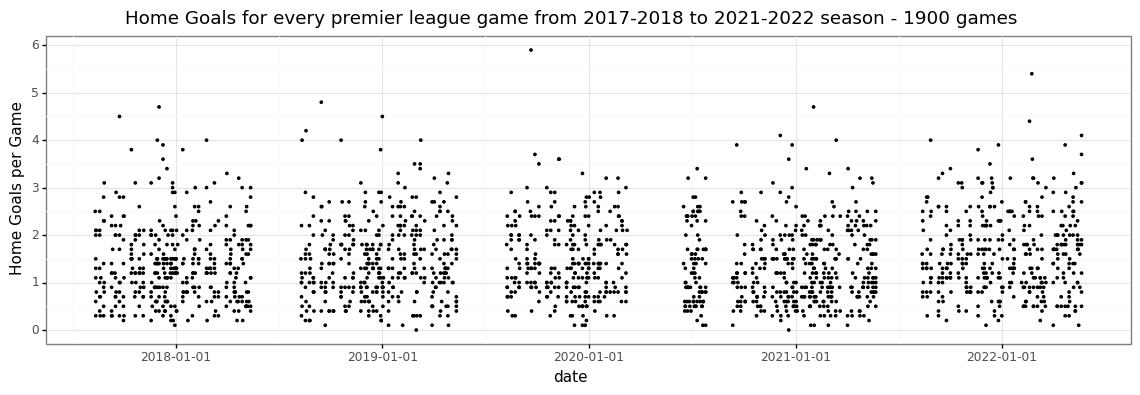

In [5]:
df1 = df_orig.copy()
p = (ggplot(df1, aes(x='date', y='h_xg')) +
     geom_point(size=0.5) +
     scale_y_continuous(breaks=np.linspace(0, 10, 11)) +
     ylab('Home Goals per Game') +
     # xlab('game #') +
     labs(title=f'Home Goals for every premier league game from 2017-2018 to 2021-2022 season - {len(df1)} games') +
     theme(figure_size=(14, 4))
    )
p.draw();

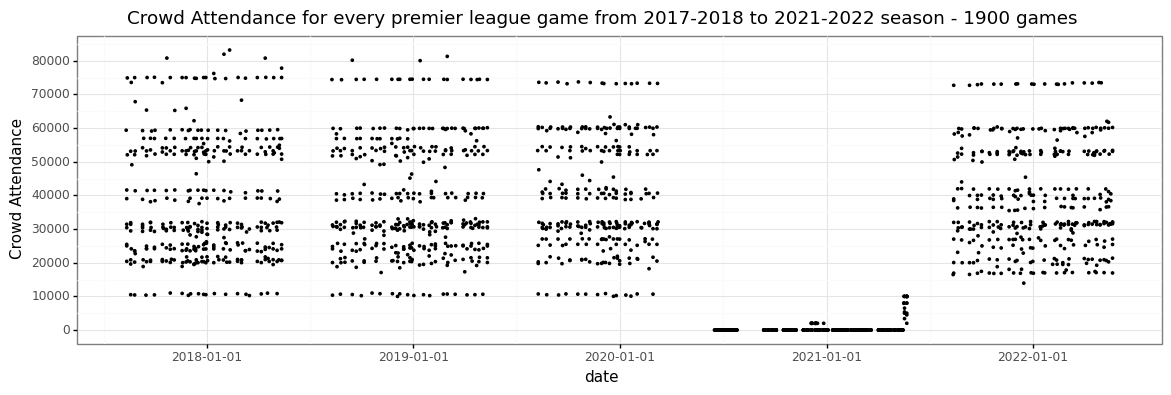

In [6]:
df1 = df_orig.copy()
p = (ggplot(df1, aes(x='date', y='attendance')) +
     geom_point(size=0.5) +
     scale_y_continuous(breaks=np.linspace(0, 100000, 11)) +
     ylab('Crowd Attendance') +
     # xlab('game #') +
     labs(title=f'Crowd Attendance for every premier league game from 2017-2018 to 2021-2022 season - {len(df1)} games') +
     theme(figure_size=(14, 4))
    )
p.draw();

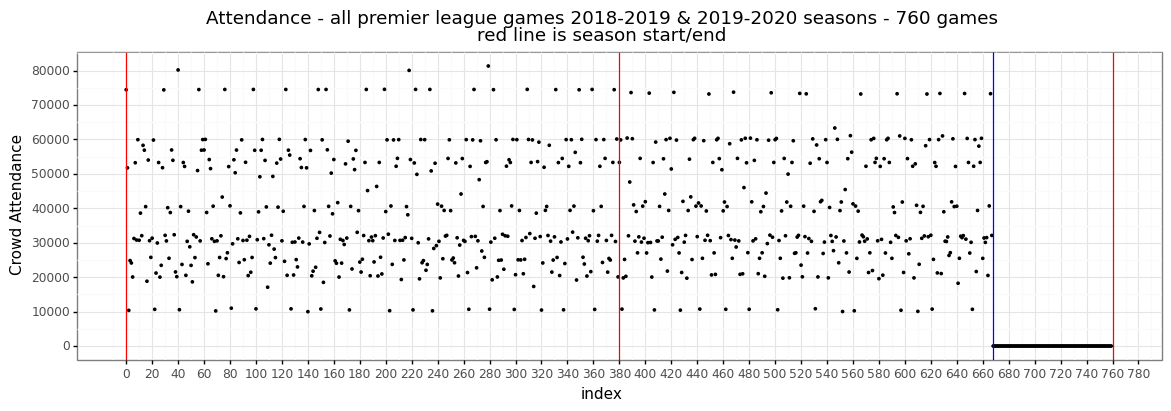

In [7]:
df2 = df_orig.copy()
seasons = ('2018-2019', '2019-2020')
df2 = df2[df2['season-key'].isin(seasons)].drop(columns=['index']).reset_index(drop=True).reset_index()

p = (ggplot(df2, aes(x='index', y='attendance')) +
     geom_point(size=0.5) +
     scale_y_continuous(breaks=np.linspace(0, 100000, 11)) +
     scale_x_continuous(breaks=np.linspace(0, 800, 41)) +
     geom_vline(xintercept=0, color='red') +
     geom_vline(xintercept=380, color='red') +
     geom_vline(xintercept=760, color='red') +
     geom_vline(xintercept=379 + 289, color='blue') +
     ylab('Crowd Attendance') +
     labs(title=f'Attendance - all premier league games 2018-2019 & 2019-2020 seasons - {len(df2)} games\nred line is season start/end') +
     theme(figure_size=(14, 4))
    )
p.draw();

In [8]:
# help(geom_vline)

In [9]:
df2[df2['attendance']==0].head()

,index,wk,date,time,h,h_ftgoals,h_xg,a,a_ftgoals,a_xg,attendance,season-key,pc(hwin),pc(draw),pc(awin)
668,668,28,2020-06-17,18:00,Aston-Villa,0.0,1.4,Sheffield-Utd,0.0,0.3,0.0,2019-2020,0.293925,0.289577,0.416498
669,669,28,2020-06-17,20:15,Manchester-City,3.0,2.6,Arsenal,0.0,0.3,0.0,2019-2020,0.754733,0.147516,0.097752
670,670,30,2020-06-19,18:00,Norwich-City,0.0,0.6,Southampton,3.0,1.7,0.0,2019-2020,0.330579,0.279575,0.389846
671,671,30,2020-06-19,20:15,Tottenham,1.0,0.4,Manchester-Utd,1.0,1.7,0.0,2019-2020,0.288761,0.278097,0.433142
672,672,30,2020-06-20,12:30,Watford,1.0,1.3,Leicester-City,1.0,1.0,0.0,2019-2020,0.258719,0.284290,0.456990


## 2018 - 2019 xG

In [10]:
target = 'h_xg'

In [11]:
# Write function to make summary dataframe of counts
df3 = df_orig.copy()
df3['h_xg'] = df3['h_xg'].clip(0.01,)
seasons = ('2018-2019',)
df3 = df3[df3['season-key'].isin(seasons)].drop(columns=['index']).reset_index(drop=True).reset_index()
droppers = ['attendance', 'season-key', 'pc(hwin)', 'pc(draw)', 'pc(awin)']
df3 = df3.drop(columns=droppers)
# df3['xg_diff'] = df3['h_xg'] - df3['a_xg']
top = df3.copy()
top['goals'] = top['h_xg']
top['home'] = 1
df3['h_xg_log'] = np.log(df3['h_xg'].values)
df3.head()

,index,wk,date,time,h,h_ftgoals,h_xg,a,a_ftgoals,a_xg,h_xg_log
0,0,1,2018-08-10,20:00,Manchester-Utd,2.0,1.5,Leicester-City,1.0,1.8,0.405465
1,1,1,2018-08-11,12:30,Newcastle-Utd,1.0,1.0,Tottenham,2.0,2.0,0.000000
2,2,1,2018-08-11,15:00,Bournemouth,2.0,2.2,Cardiff-City,0.0,1.4,0.788457
3,3,1,2018-08-11,15:00,Fulham,0.0,0.7,Crystal-Palace,2.0,1.0,-0.356675
4,4,1,2018-08-11,15:00,Huddersfield,0.0,0.3,Chelsea,3.0,1.9,-1.203973


In [12]:
target = 'h_xg_log'

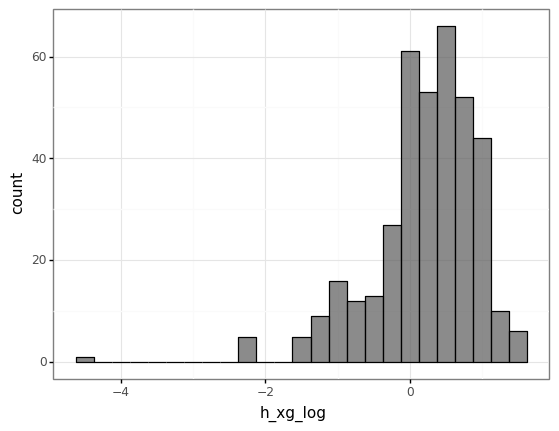

In [13]:
p = (ggplot(df3, aes(target)) +
     geom_histogram(binwidth=0.25, alpha=0.7, color='black')
    )
p.draw();

In [14]:
df3['h_xg'].min()

0.01

In [15]:
def quantiles(df_orig, cat_col, var_col, q_method='inverted_cdf'):
    
    rem_df = df_orig.copy()
    rem_df = rem_df[[col for col in rem_df.columns if col not in [cat_col, var_col]]]
    # print(rem_df)

    cat_dfs = []
    for cat, cat_df in df_orig.groupby(by=cat_col):
        cat_df = cat_df.sort_values(by=var_col)
        i = np.arange(0, len(cat_df), 1) + 1
        cat_df['f-value'] = (i - 0.5) / len(cat_df)
        cat_df[var_col] = np.quantile(cat_df[var_col], cat_df['f-value'].values, interpolation='linear')
        cat_dfs.append(cat_df)
    f_df = pd.concat(cat_dfs, axis=0)
    df = pd.concat([rem_df, f_df], axis=1).reset_index()

    return f_df

In [16]:
q2 = quantiles(df3.assign(all=1), 'all', target, q_method='inverted_cdf')
q2.head()
# q2 = quantiles(df, 'voice_part', 'height', q_method='inverted_cdf')
# q2.head()

,index,wk,date,time,h,h_ftgoals,h_xg,a,a_ftgoals,a_xg,h_xg_log,all,f-value
280,280,29,2019-03-02,15:00,Bournemouth,0.0,0.01,Manchester-City,1.0,1.2,-3.456907,1,0.001316
250,250,27,2019-02-06,19:45,Everton,0.0,0.10,Manchester-City,2.0,2.2,-2.302585,1,0.003947
310,310,32,2019-03-30,17:30,West-Ham,0.0,0.10,Everton,2.0,1.8,-2.302585,1,0.006579
213,213,22,2019-01-12,15:00,Cardiff-City,0.0,0.10,Huddersfield,0.0,0.5,-2.302585,1,0.009211
52,52,6,2018-09-22,15:00,Cardiff-City,0.0,0.10,Manchester-City,5.0,2.5,-2.302585,1,0.011842


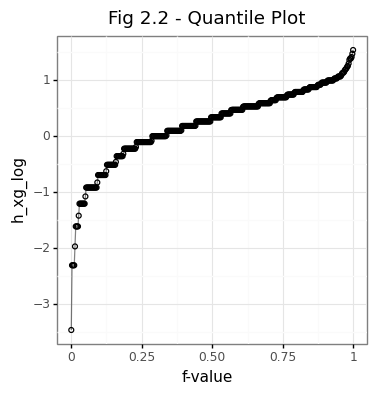

In [17]:
p = (ggplot(q2, aes(x="f-value", y=target)) +
     geom_point(fill='none') +
     geom_line(alpha=0.5) + 
     # facet_wrap(facets='voice_part', nrow=4, ncol=2, as_table=False) +
     theme_bw() +
     # theme(figure_size=(4,4)) +
     theme(figure_size=(4,4)) +
     labs(title="Fig 2.2 - Quantile Plot",
          caption='2.2 The symbols and the line\nsegments show the quantile\nfunction of the first tenor heights.'))
p.draw();

In [18]:
def theoretical_qq(df, cat_col, var_col, dist='norm'):
    # cat_type=CategoricalDtype(categories=df[cat_col].cat.categories, ordered=True)
    
    qdfs = []
    for cat, cat_df in df.groupby(by=cat_col):
        xys, line_def = stats.probplot(cat_df[var_col].values, dist=dist)
        qdf = pd.DataFrame({cat_col: cat, 'theory_quantiles': xys[0], var_col: xys[1],
                            'slope': line_def[0], 'intercept': line_def[1]})
        qdfs.append(qdf)
        
    df = pd.concat(qdfs, axis=0).reset_index(drop=True)
    # df[cat_col] = df[cat_col].astype(cat_type)
    return df 

In [19]:
qq_norms = theoretical_qq(df3.assign(all=1), 'all', target, dist='norm')
qq_norms.head()

,all,theory_quantiles,h_xg_log,slope,intercept
0,1,-2.907370,-4.605170,0.694862,0.199733
1,1,-2.617920,-2.302585,0.694862,0.199733
2,1,-2.454581,-2.302585,0.694862,0.199733
3,1,-2.338468,-2.302585,0.694862,0.199733
4,1,-2.247296,-2.302585,0.694862,0.199733


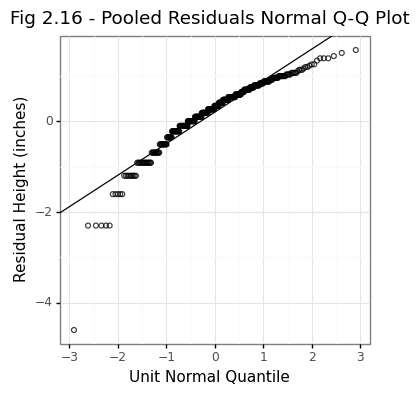

In [20]:
p = (ggplot(qq_norms, aes(x='theory_quantiles', y=target)) +
     geom_point(fill='none', alpha=0.75) +
     geom_abline(aes(intercept='intercept', slope='slope', alpha=0.5)) +
     labs(title="Fig 2.16 - Pooled Residuals Normal Q-Q Plot",
          caption='2.16 A normal q-q plot compares\nthe distribution of the pooled\nresiduals with a normal distribution.') +
     theme_bw() + 
     xlab("Unit Normal Quantile") + 
     ylab("Residual Height (inches)") +
     # facet_wrap('~voice_part', ncol=2, as_table=False) +
     theme(legend_position='none') +
     theme(figure_size=(4, 4))
    )
p.draw();

# Goal Data

In [21]:
# p = (ggplot(density_df, aes('x', 'density')) +
#      geom_line()     
#     )
# p.draw();

In [22]:
target = 'h_ftgoals'

In [23]:

df3 = df_orig.copy()
seasons = ('2018-2019',)
df3 = df3[df3['season-key'].isin(seasons)].drop(columns=['index']).reset_index(drop=True).reset_index()
droppers = ['attendance', 'season-key', 'pc(hwin)', 'pc(draw)', 'pc(awin)']
df3 = df3.drop(columns=droppers)
df3['home'] = np.NaN
top = df3.copy()
top['goals'] = top['h_ftgoals']
top['home'] = 1

bottom = df3.copy()
bottom['goals'] = bottom['a_ftgoals']
bottom['home'] = 0

df3 = pd.concat([top, bottom], axis=0).reset_index(drop=True)
# df3['home'] = df3['home']. astype(cattype)
df3

# keepers = ['index', 'wk', 'date', 'time', 'h', 'a', 'h_ftgoals
df3.head()

,index,wk,date,time,h,h_ftgoals,h_xg,a,a_ftgoals,a_xg,home,goals
0,0,1,2018-08-10,20:00,Manchester-Utd,2.0,1.5,Leicester-City,1.0,1.8,1,2.0
1,1,1,2018-08-11,12:30,Newcastle-Utd,1.0,1.0,Tottenham,2.0,2.0,1,1.0
2,2,1,2018-08-11,15:00,Bournemouth,2.0,2.2,Cardiff-City,0.0,1.4,1,2.0
3,3,1,2018-08-11,15:00,Fulham,0.0,0.7,Crystal-Palace,2.0,1.0,1,0.0
4,4,1,2018-08-11,15:00,Huddersfield,0.0,0.3,Chelsea,3.0,1.9,1,0.0


In [24]:
df3.tail()

,index,wk,date,time,h,h_ftgoals,h_xg,a,a_ftgoals,a_xg,home,goals
755,375,38,2019-05-12,15:00,Liverpool,2.0,1.6,Wolves,0.0,1.3,0,0.0
756,376,38,2019-05-12,15:00,Manchester-Utd,0.0,1.5,Cardiff-City,2.0,1.6,0,2.0
757,377,38,2019-05-12,15:00,Southampton,1.0,0.6,Huddersfield,1.0,0.7,0,1.0
758,378,38,2019-05-12,15:00,Tottenham,2.0,0.6,Everton,2.0,2.0,0,2.0
759,379,38,2019-05-12,15:00,Watford,1.0,2.2,West-Ham,4.0,3.1,0,4.0


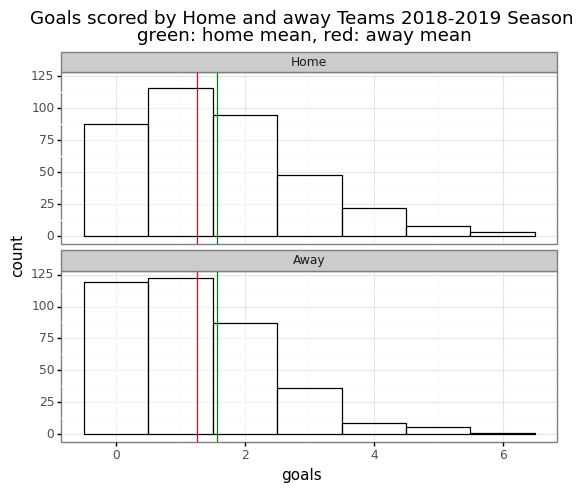

In [25]:
def col_func(s):
    return {'0':'Away', '1': 'Home'}[s]

p = (ggplot(df3, aes('goals', group='home')) +
     geom_histogram(binwidth=1, alpha=0.5, fill='white', color='black') +
     facet_wrap('~home', ncol=1, labeller=labeller(cols=col_func), as_table=False) +
     geom_vline(xintercept=df3[df3['home']==1]['goals'].mean(), color='green') +
     geom_vline(xintercept=df3[df3['home']==0]['goals'].mean(), color='red') +
     labs(title='Goals scored by Home and away Teams 2018-2019 Season\n green: home mean, red: away mean')
    )
p.draw();

# Is Poisson Distribution a reasonable fit?

In [26]:
df3

,index,wk,date,time,h,h_ftgoals,h_xg,a,a_ftgoals,a_xg,home,goals
0,0,1,2018-08-10,20:00,Manchester-Utd,2.0,1.5,Leicester-City,1.0,1.8,1,2.0
1,1,1,2018-08-11,12:30,Newcastle-Utd,1.0,1.0,Tottenham,2.0,2.0,1,1.0
2,2,1,2018-08-11,15:00,Bournemouth,2.0,2.2,Cardiff-City,0.0,1.4,1,2.0
3,3,1,2018-08-11,15:00,Fulham,0.0,0.7,Crystal-Palace,2.0,1.0,1,0.0
4,4,1,2018-08-11,15:00,Huddersfield,0.0,0.3,Chelsea,3.0,1.9,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
755,375,38,2019-05-12,15:00,Liverpool,2.0,1.6,Wolves,0.0,1.3,0,0.0
756,376,38,2019-05-12,15:00,Manchester-Utd,0.0,1.5,Cardiff-City,2.0,1.6,0,2.0
757,377,38,2019-05-12,15:00,Southampton,1.0,0.6,Huddersfield,1.0,0.7,0,1.0
758,378,38,2019-05-12,15:00,Tottenham,2.0,0.6,Everton,2.0,2.0,0,2.0


In [27]:
home_obs_dist = df3[df3['home']==1]['goals'].value_counts() / len(df3[df3['home']==0])
home_obs_dist = home_obs_dist.sort_index()
home_obs_dist

0.0    0.231579
1.0    0.305263
2.0    0.250000
3.0    0.126316
4.0    0.057895
5.0    0.021053
6.0    0.007895
Name: goals, dtype: float64

In [28]:
home_theory_dist = stats.poisson.pmf(home_obs_dist.index, df3[df3['home']==1]['goals'].mean())
home_theory_dist

array([0.20837393, 0.32681807, 0.25629417, 0.13399239, 0.05253912,
       0.01648069, 0.00430811])

In [29]:
home_dists = pd.DataFrame({'goals': home_obs_dist.index, 'obs': home_obs_dist.values, 'poiss': home_theory_dist, 'home': 1})
home_dists

,goals,obs,poiss,home
0,0.0,0.231579,0.208374,1
1,1.0,0.305263,0.326818,1
2,2.0,0.250000,0.256294,1
3,3.0,0.126316,0.133992,1
4,4.0,0.057895,0.052539,1
5,5.0,0.021053,0.016481,1
6,6.0,0.007895,0.004308,1


In [30]:
away_obs_dist = df3[df3['home']==0]['goals'].value_counts() / len(df3[df3['home']==0])
away_obs_dist = away_obs_dist.sort_index()
# away_obs_dist

In [31]:
away_theory_dist = stats.poisson.pmf(np.linspace(0, 6, 7), df3[df3['home']==0]['goals'].mean())
# away_theory_dist

In [32]:
away_dists = pd.DataFrame({'goals': away_obs_dist.index, 'obs': away_obs_dist.values, 'poiss': away_theory_dist, 'home': 0})
away_dists

,goals,obs,poiss,home
0,0.0,0.313158,0.285752,0
1,1.0,0.321053,0.357942,0
2,2.0,0.228947,0.224185,0
3,3.0,0.094737,0.093607,0
4,4.0,0.023684,0.029314,0
5,5.0,0.015789,0.007344,0
6,6.0,0.002632,0.001533,0


In [33]:
df4 = pd.concat([home_dists, away_dists], axis=0)
df4.head()

,goals,obs,poiss,home
0,0.0,0.231579,0.208374,1
1,1.0,0.305263,0.326818,1
2,2.0,0.250000,0.256294,1
3,3.0,0.126316,0.133992,1
4,4.0,0.057895,0.052539,1


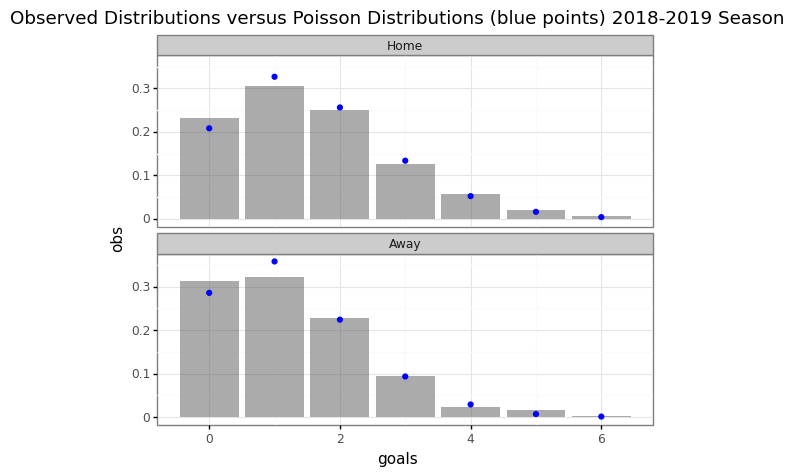

In [34]:
p = (ggplot(df4, aes(x='goals', y='obs', group='home')) +
     # geom_histogram(binwidth=1, alpha=0.5, fill='white', color='black') +
     geom_col(alpha=0.5) + # binwidth=1, alpha=0.5, fill='white', color='black') +
     geom_point(aes(x='goals', y='poiss'), color='blue') +
     # geom_histogram(aes(y="stat_density"), binwidth=1, alpha=0.5, fill='white', color='black') +
     # facet_wrap('~home', ncol=1)
     # geom_histogram(aes('h_ftgoals'), binwidth=1, alpha=0.3, color='green') +
     # geom_histogram(aes('a_ftgoals'), binwidth=1, alpha=0.3, color='red')  
     facet_wrap('~home', ncol=1, labeller=labeller(cols=col_func), as_table=False) +
     # geom_vline(xintercept=df3[df3['home']==1]['goals'].mean(), color='green') +
     # geom_vline(xintercept=df3[df3['home']==0]['goals'].mean(), color='red') +
     labs(title='Observed Distributions versus Poisson Distributions (blue points) 2018-2019 Season')
    )
p.draw();

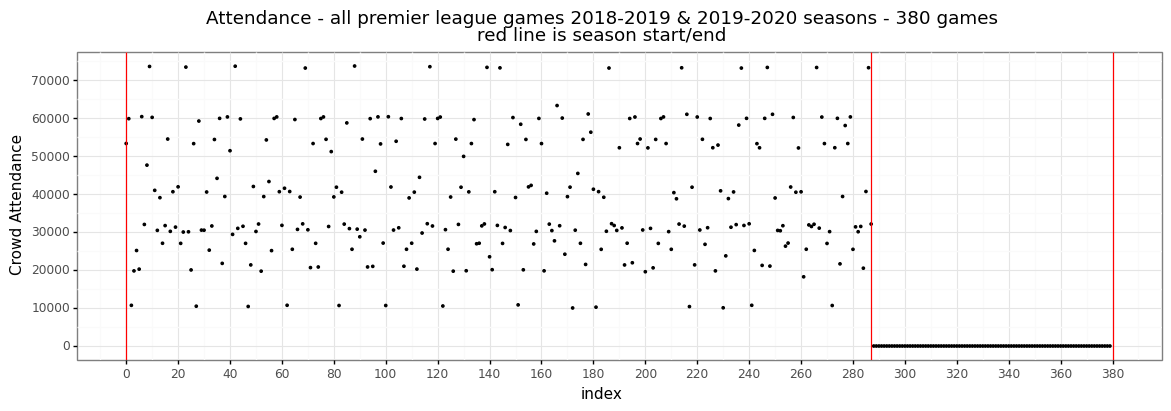

In [35]:
df2 = df_orig.copy()
seasons = ('2019-2020',)
df2 = df2[df2['season-key'].isin(seasons)].drop(columns=['index']).reset_index(drop=True).reset_index()

p = (ggplot(df2, aes(x='index', y='attendance')) +
     geom_point(size=0.5) +
     scale_y_continuous(breaks=np.linspace(0, 100000, 11)) +
     scale_x_continuous(breaks=np.linspace(0, 800, 41)) +
     geom_vline(xintercept=0, color='red') +
     geom_vline(xintercept=380, color='red') +
     geom_vline(xintercept=287, color='red') +
     ylab('Crowd Attendance') +
     labs(title=f'Attendance - all premier league games 2018-2019 & 2019-2020 seasons - {len(df2)} games\nred line is season start/end') +
     theme(figure_size=(14, 4))
    )
p.draw();

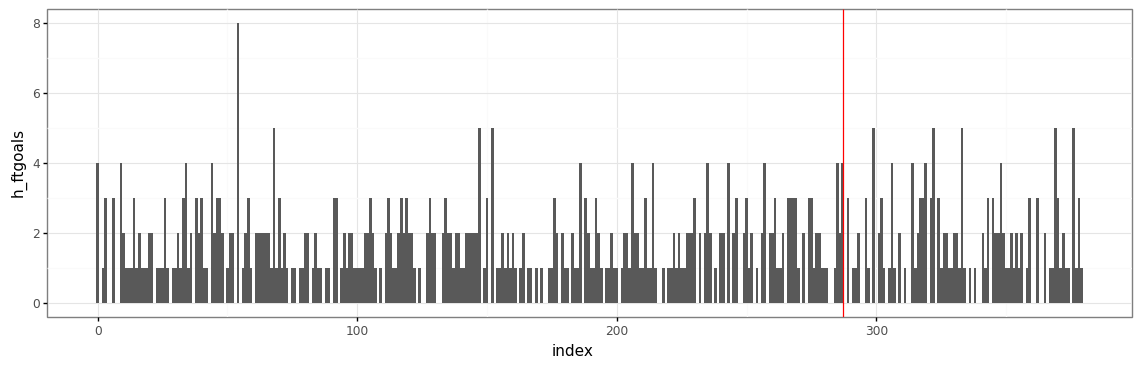

In [36]:
# df2 = df_orig.copy()
# seasons = ('2019-2020',)
# df2 = df2[df2['season-key'].isin(seasons)].drop(columns=['index']).reset_index(drop=True).reset_index()

p = (ggplot(df2, aes(x='index', y=target)) +
     geom_col(width=1.0) +
     # scale_y_continuous(breaks=np.linspace(0, 100000, 11)) +
     # scale_x_continuous(breaks=np.linspace(0, 800, 41)) +
     # geom_vline(xintercept=0, color='red') +
     # geom_vline(xintercept=380, color='red') +
     geom_vline(xintercept=287, color='red') +
     # ylab('Crowd Attendance') +
     # labs(title=f'Attendance - all premier league games 2018-2019 & 2019-2020 seasons - {len(df2)} games\nred line is season start/end') +
     theme(figure_size=(14, 4))
    )
p.draw();

In [54]:
df2[df2['attendance']!=0]['h_ftgoals'].mean()

1.5069444444444444

In [55]:
df2[df2['attendance']==0]['h_ftgoals'].mean()

1.5434782608695652

In [37]:
# df2 = df_orig.copy()
# seasons = ('2018-2019',)
# df2 = df2[df2['season-key'].isin(seasons)].drop(columns=['index']).reset_index(drop=True).reset_index()

# p = (ggplot(df2, aes(x='index', y='a_ftgoals')) +
#      geom_col(width=1.0) +
#      # scale_y_continuous(breaks=np.linspace(0, 100000, 11)) +
#      # scale_x_continuous(breaks=np.linspace(0, 800, 41)) +
#      # geom_vline(xintercept=0, color='red') +
#      # geom_vline(xintercept=380, color='red') +
#      geom_vline(xintercept=287, color='red') +
#      # ylab('Crowd Attendance') +
#      # labs(title=f'Attendance - all premier league games 2018-2019 & 2019-2020 seasons - {len(df2)} games\nred line is season start/end') +
#      theme(figure_size=(14, 4))
#     )
# p.draw();

# Home Goals Model

In [38]:
# target = target'a_xg'
with pm.Model() as model:
    
    
    # Prior distributions
    # ALTERNATIVE PRIORS NEXT 3 LINES
    alpha = 1.0/df2[target].mean() # The mean count per day across the full dataset
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)

    # Eyeballing the data, a typical day produces maybe 15 text messages, with lowest about 5, and highest say at 40
    # So, maybe can swap out exponential prior for normal mean =15, sd = (25 - 5)/6 = 20/6 ~ 3.5
    # But this is not trying to capture the distribution of the data,
    # it is trying to capture the distribution of the lambda parameters so make sd = 2
    # This works, but if sigma goes too high eg at 5.5, pymc chokes - probably because negative values in prior don't make sense
    # Complains with "ValueError: Domain error in arguments."
    # Obviously, this may choke again if the seed is changed so we get lambdas closer to 0
    # ALTERNATIVE PRIORS NEXT 4 LINES 
    # mu = 15
    # sigma = 2.0
    # lambda_1 = pm.Normal("lambda_1", mu, sigma)
    # lambda_2 = pm.Normal("lambda_2", mu, sigma)

    # Constrain prior on tau to be the change window
    # tau = pm.DiscreteUniform("tau", lower=stable_period, upper=stable_period + change_window)
    tau = 287
    
    # Function?
    idx = np.arange(len(df2)) # Index
    # print(idx)
    # From docs - if cond then ift else iff - ?? What does this mean? If cond true, then do first else do second?
    # docs seem a bit scant for a novice to interpret
    # Don't get this - if this was right then surely cond would be tau < idx 
    # The only way I can read this is as - If tau > switch index then lambda 2 else lambda 1
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)
    
    # pm.Poisson - This is the only place I see poisson
    # Is this saying that the observed data should be modeled using a poisson distribution?
    # observation = pm.Poisson("obs", lambda_, observed=df_samples['count'].values)
    observation = pm.Poisson("obs", lambda_, observed=df2[target].values)

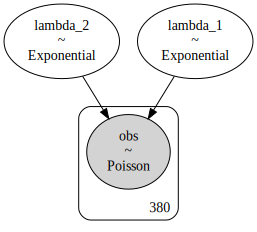

In [39]:
pm.model_to_graphviz(model)

In [40]:
with model:
    prior = pm.sample_prior_predictive(1000)

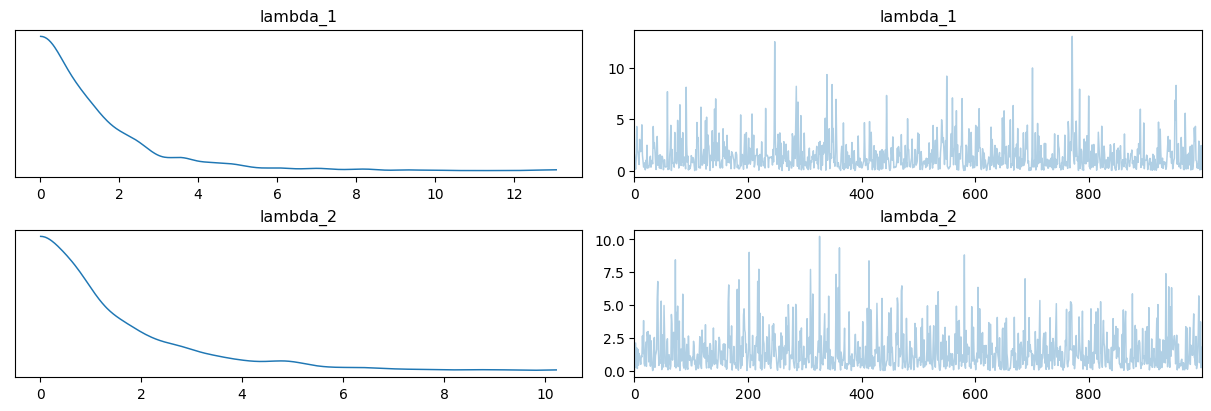

In [41]:
# This warns loudly about stats/density_utils.py:606: UserWarning: Something failed: `x` does not contain any finite number.
# I think this code is used to plot the densities, so not sure why this is complaining, but it does produce 3 plots
# of the priors.

# Hiding warnings for readability
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pm.plot_trace(prior, ['lambda_1', 'lambda_2'])
    plt.show()

In [42]:
# This shows the prior predictive distributions before any data is fitted
# So it seems that many priors could get us to this point
# However, this prior predictive data may be clearer if it made use of the switch function to plot the means
# So, for better clarity, this could be plotted on the time axis, but it means expanding the prior data to give it a day index
# so it can be plotted as 500 time series
priorpred_df = pd.DataFrame({'lambda_1': prior['lambda_1'], 'lambda_2': prior['lambda_2'], 'tau': tau})
priorpred_df.head()

,lambda_1,lambda_2,tau
0,1.517528,0.000268,287
1,0.897058,0.993453,287
2,0.129676,2.103557,287
3,1.104249,0.233795,287
4,4.297073,1.725108,287


In [43]:
exp_dfs = []
for idx, row in priorpred_df.iterrows():
    days_at_1 = int(row.tau)
    days_at_2 = int(380 - days_at_1)
    lam1 = [row.lambda_1] * days_at_1
    lam2 = [row.lambda_2] * days_at_2
    lam1.extend(lam2)
    exp_df = pd.DataFrame({'match_num': range(0, 380), 'lambda': lam1, 'sample_num': idx})
    exp_dfs.append(exp_df)
priorpredexp_df = pd.concat(exp_dfs, axis=0).reset_index(drop=True)
print(len(priorpredexp_df))
priorpredexp_df.head()

380000


,match_num,lambda,sample_num
0,0,1.517528,0
1,1,1.517528,0
2,2,1.517528,0
3,3,1.517528,0
4,4,1.517528,0


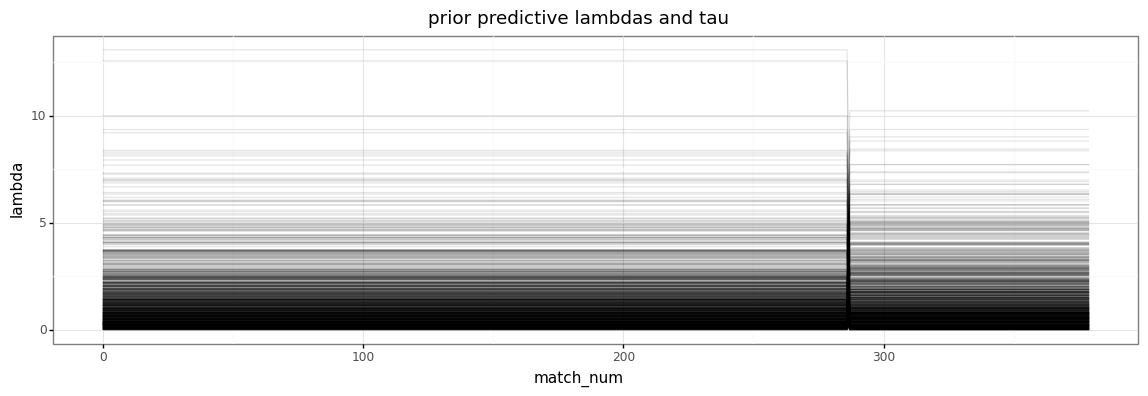

In [44]:
p = (ggplot(priorpredexp_df, aes(x='match_num', y='lambda', group='sample_num')) +
     geom_line(alpha=0.1) +
     labs(title="prior predictive lambdas and tau") +
     theme(figure_size=(14, 4)))
p.draw();


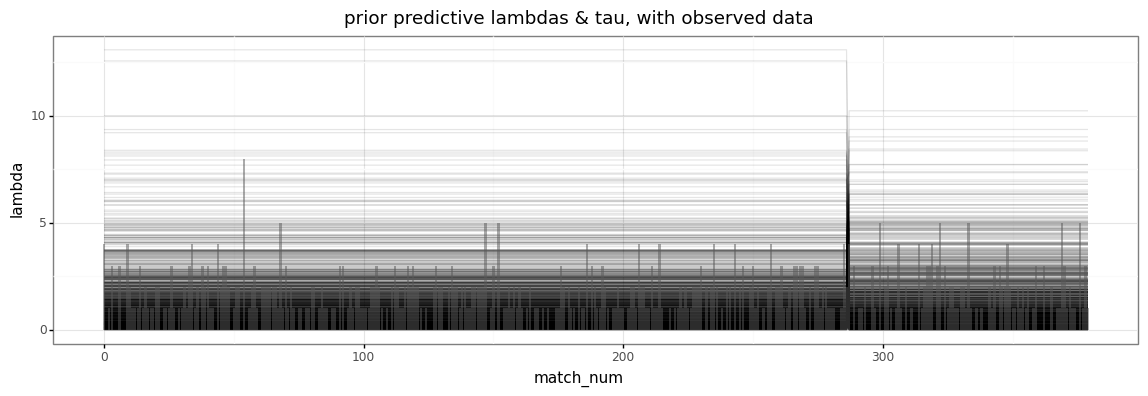

In [45]:
# Seems like have to insert this column to get plotnine to play nice with 2 datasets
df2['sample_num'] = priorpredexp_df['sample_num'].max() + 1

p = (ggplot(priorpredexp_df, aes(x='match_num', y='lambda', group='sample_num')) +
     geom_line(alpha=0.1) +
     geom_col(df2, aes(x='index', y=target), alpha=0.5) +  
     labs(title="prior predictive lambdas & tau, with observed data") +
     theme(figure_size=(14, 4)))
p.draw();

In [46]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000, step=step, return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 6 seconds.
The number of effective samples is smaller than 25% for some parameters.


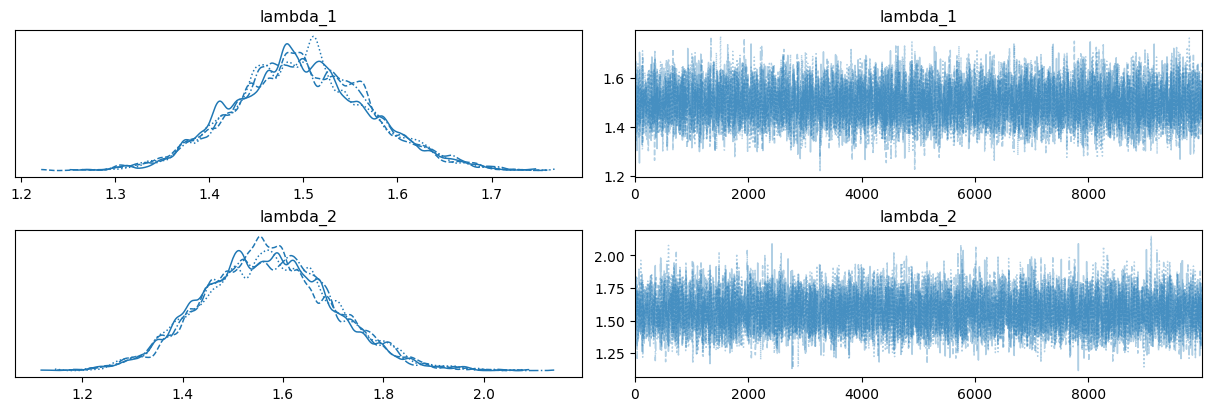

In [47]:
with model:
    pm.plot_trace(trace, ['lambda_1', 'lambda_2'])
    plt.show()

In [48]:
# Use the same analysis code as was used for the prior predictive stuff
trace_df = pd.DataFrame({'lambda_1': trace['lambda_1'], 'lambda_2': trace['lambda_2'], 'tau': tau})
trace_df.head()

,lambda_1,lambda_2,tau
0,1.628085,1.668166,287
1,1.628085,1.668166,287
2,1.639168,1.668166,287
3,1.607445,1.668166,287
4,1.607445,1.668166,287


In [49]:
# Expand the df by making each row into a 70 day long df and concatenating on top of each other to suit plotnine
# same code as used for prior model
exp_dfs = []
for idx, row in trace_df.iterrows():
    days_at_1 = int(row.tau)
    days_at_2 = int(380 - days_at_1)
    lam1 = [row.lambda_1] * days_at_1
    lam2 = [row.lambda_2] * days_at_2
    lam1.extend(lam2)
    exp_df = pd.DataFrame({'match_num': range(0, 380), 'lambda': lam1, 'sample_num': idx})
    exp_dfs.append(exp_df)
traceexp_df = pd.concat(exp_dfs, axis=0).reset_index(drop=True)
traceexp_df.head()

,match_num,lambda,sample_num
0,0,1.628085,0
1,1,1.628085,0
2,2,1.628085,0
3,3,1.628085,0
4,4,1.628085,0


In [50]:
traceexp_df['sample_num'].max()

39999

In [51]:
np.random.seed(SEED)
print(len(traceexp_df))
# the expanded trace dataframe is a bit big
# To make it comparable to the prior predictive plot - cut it down to 1000 randomly chosen sample sets
samp_size = 1000
start = stats.randint.rvs(0, traceexp_df['sample_num'].max() - samp_size)
traceexpcut_df = traceexp_df[traceexp_df['sample_num'].isin(range(start, start + samp_size))]
print(len(traceexpcut_df))

15200000
380000


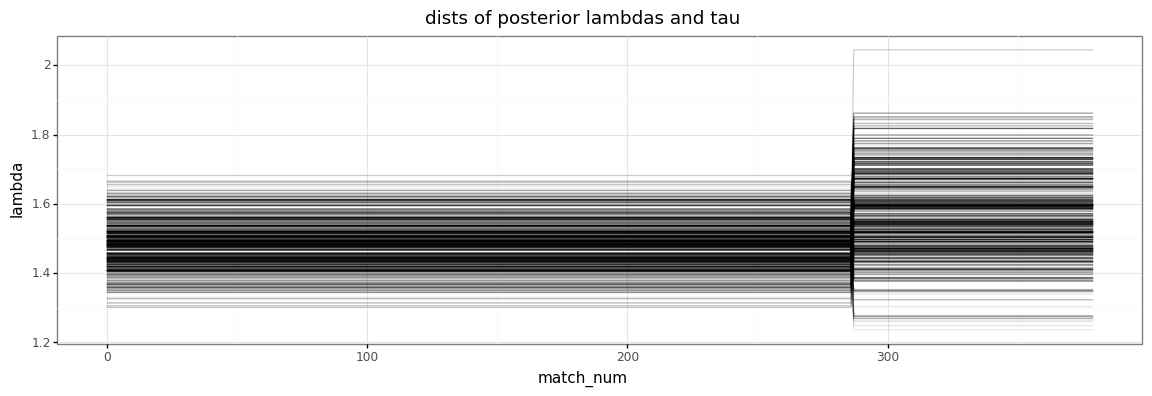

In [52]:
p = (ggplot(traceexpcut_df, aes(x='match_num', y='lambda', group='sample_num')) +
     geom_line(alpha=0.1) +
     labs(title="dists of posterior lambdas and tau") +
     theme(figure_size=(14, 4)))
p.draw();

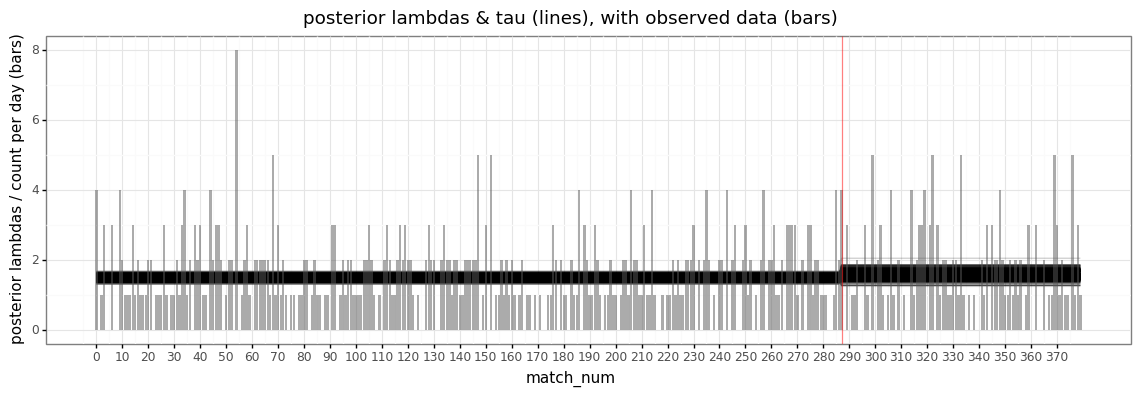

In [53]:
# Seems like have to insert this column to get plotnine to play nice with 2 datasets
# df_rawdata['sample_num'] = traceexpcut_df['sample_num'].max() + 1

p = (ggplot(traceexpcut_df, aes(x='match_num', y='lambda', group='sample_num')) +
     geom_line(alpha=0.1) +
     geom_col(df2, aes(x='index', y=target), alpha=0.5) +  
     geom_vline(xintercept=tau, alpha=0.5, color='red') +
     # geom_vline(xintercept=stable_period + change_window, alpha=0.5, color='red') +
     labs(title="posterior lambdas & tau (lines), with observed data (bars)") +
     ylab('posterior lambdas / count per day (bars)') +
     scale_x_continuous(breaks=np.arange(0, 380, 10)) +
     theme(figure_size=(14, 4)))
p.draw();